# Demo de implementación de un algoritmo de Programación Genética para obtener un procedimiento que ordene una lista de valores numéricos
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

In [1]:
#@title Instalar librerías

# instala paquetes DEAP
!pip install deap

# instala paquetes gráficos
!apt-get install -y graphviz-dev
!pip install pygraphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 20 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,03

In [2]:
#@title Cargar librerías
import random
import numpy as np

import operator
import math

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import random
import copy

import matplotlib.pyplot as plt
import pygraphviz as pgv
from IPython.display import display
import tempfile
from PIL import Image
#import networkx as nx

print("\nLibrerías importadas")


Librerías importadas


In [3]:
#@title GENERAR LOS DATOS DE LAS LISTAS EN FORMA ALETATORIAGENERAR LOS DATOS DE LAS LISTAS EN FORMA ALETATORIA
Cantidad_Listas = 5 #@param {type:"slider", min:1, max:10, step:1}
Cantidad_Maxima_Elementos_Listas = 10 #@param {type:"slider", min:2, max:100, step:1}
Min_Valor_Elemento = 0 #@param {type:"slider", min:-100, max:0, step:1}
Max_Valor_Elemento = 100 #@param {type:"slider", min:1, max:100, step:1}

# genera los valores de las listas al azar
LISTA = []
for i in range(Cantidad_Listas):
  auxL = []
  cantElemRnd = random.randint(2, Cantidad_Maxima_Elementos_Listas)
  for j in range(cantElemRnd):
    auxL.append( random.randint(Min_Valor_Elemento, Max_Valor_Elemento) )
  print("Lista a ordenar ", i+1, ": ", auxL)
  LISTA.append(auxL)


Lista a ordenar  1 :  [57, 62, 60, 34, 95, 74]
Lista a ordenar  2 :  [46, 52, 50, 87, 32, 30, 97]
Lista a ordenar  3 :  [97, 75, 61, 32, 10, 15, 79, 36, 55, 77]
Lista a ordenar  4 :  [54, 58, 16, 24, 91, 35, 9, 19, 34, 27]
Lista a ordenar  5 :  [98, 87, 72, 58, 81, 43, 14, 14, 74]


In [4]:
#@title DEFINIR FUNCIÓN DE APTITUD y PRIMITIVAS DEL CROMOSOMA


#@markdown > Función de Aptitud:
#@markdown - indica que es para minimizar.
#@markdown - determina la aptitud a partir de la sumatoria de la cantidad de errores en las listas a ordenary considerando la cantidad de operadores del cromosoma (para reducir BLOAT).


#@markdown > Estructura del Cromosoma:
#@markdown - indicar debajo tipos de primitivas a usar:
incluye_Primitivas_OperacionesNumericas_MinMax = True #@param {type:"boolean"}
incluye_Primitivas_OperacionesNumericas_Aritmeticas = False #@param {type:"boolean"}
incluye_Primitivas_Devolver_Mayor_y_Menor = True #@param {type:"boolean"}
incluye_Primitivas_Adelantar_y_Atrasar = True #@param {type:"boolean"}
incluye_Primitiva_Mover = False #@param {type:"boolean"}
incluye_Constantes_Aleatorias = 1 #@param {type:"slider", min:0, max:5, step:1}


## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

## Define las primitivas a usar para ordenar la lista

# devuelve la posición con el mayor valor entre la pos 1 y la pos 2
def cualEsMayor(lista, pos1, pos2):
  # chequea que las posiciones no se encuentran fuera de la lista
  if (pos1 < 0) or (pos2 < 0):
    if (pos2 < 0):
      if (pos1 < 0):
        return 0
      else:
        return pos1
    else:
      return pos2
  if (pos1 >= len(lista)) or (pos2 >= len(lista)):
    if (pos2 >= len(lista)):
      if (pos1 >= len(lista)):
        return len(lista)-1
      else:
        return pos1
    else:
      return pos2
  # compara los valores
  if lista[pos1] > lista[pos2]:
    return pos1
  else:
    return pos2

# devuelve la posición con el menor valor entre la pos 1 y la pos 2
def cualEsMenor(lista, pos1, pos2):
  # chequea que las posiciones no se encuentran fuera de la lista
  if (pos1 < 0) or (pos2 < 0):
    if (pos2 < 0):
      if (pos1 < 0):
        return 0
      else:
        return pos1
    else:
      return pos2
  if (pos1 >= len(lista)) or (pos2 >= len(lista)):
    if (pos2 >= len(lista)):
      if (pos1 >= len(lista)):
        return len(lista)-1
      else:
        return pos1
    else:
      return pos2
  # compara los valores
  if lista[pos1] <= lista[pos2]:
    return pos1
  else:
    return pos2

# intercambia valores de pos1 con pos2
def intercambiar(lista, pos1, pos2):
  # chequea que las posiciones no se encuentran fuera de la lista
  if (pos1 < 0) or (pos1 >= len(lista)):
    if (pos1 < 0):
      pos1 = 0
    else:
      pos1 =  len(lista) - 1
  if (pos2 < 0) or (pos2 >= len(lista)):
    if (pos2 < 0):
      pos2 = 0
    else:
      pos2 =  len(lista) - 1
  # chequea que no sean las mismas posiciones
  if pos1 == pos2:
    return lista
  else:
    # realiza el intercambio
    lista[pos1], lista[pos2] = lista[pos2], lista[pos1]
    return lista

# devuelve la última posición de la lista (largo de la lista - 1)
def devLargoLista(lista):
  return len(lista)-1

# devuelve la posición con el menor valor de toda la lista
def devMenor(lista):
  posMenor = 0
  valMenor = None
  for pos in range(len(lista)):
    if (valMenor == None) or (lista[pos] < valMenor):
      valMenor = lista[pos]
      posMenor = pos
  return posMenor

# devuelve la posición con el mayor valor de toda la lista
def devMayor(lista):
  posMayor = 0
  valMayor = None
  for pos in range(len(lista)):
    if (valMayor == None) or (lista[pos] > valMayor):
      valMayor = lista[pos]
      posMayor = pos
  return posMayor

# mueve el valor de posAnt a posNueva
def mover(lista, posAnt, posNueva):
  # chequea que las posiciones no se encuentran fuera de la lista
  if (posAnt < 0) or (posAnt >= len(lista)):
    if (posAnt < 0):
      posAnt = 0
    else:
      posAnt =  len(lista) - 1
  if (posNueva < 0) or (posNueva >= len(lista)):
    if (posNueva < 0):
      posNueva = 0
    else:
      posNueva =  len(lista) - 1
  # chequea que no sean las mismas posiciones
  if posAnt == posNueva:
    return lista
  else:
    # realiza el intercambio
    lista.insert(posNueva, lista.pop(posAnt))
    return lista

# pone una posición más adelante al valor de pos
def adelantar(lista, pos):
  if pos <= 0:
    return lista
  else:
    return mover(lista, pos, pos-1)

# pone una posición más atrpas al valor de pos
def atrasar(lista, pos):
  if pos >= len(lista) - 1:
    return lista
  else:
    return mover(lista, pos, pos+1)

def if_then_else(condition, out1, out2):
    out1() if condition() else out2()

def pdiv(left, right):
    try:
        return int(left / right)
    except ZeroDivisionError:
        return 1

# Configura las primitivas permitidas para usar
# algunas son configurables (opcionales) y otras no
pset = gp.PrimitiveSetTyped("MAIN", [str], str)
pset.addPrimitive(intercambiar, [str, int, int], str)
pset.addPrimitive(cualEsMayor, [str, int, int], int)
pset.addPrimitive(cualEsMenor, [str, int, int], int)
pset.addPrimitive(devLargoLista, [str], int)
pset.addTerminal(0, int)
if incluye_Primitivas_OperacionesNumericas_MinMax:
  pset.addPrimitive(max, [int, int], int)
  pset.addPrimitive(min, [int, int], int)
if incluye_Primitivas_OperacionesNumericas_Aritmeticas:
  pset.addPrimitive(operator.add, [int, int], int)
  pset.addPrimitive(operator.sub, [int, int], int)
  pset.addPrimitive(operator.mul, [int, int], int)
  pset.addPrimitive(pdiv, [int, int], int)
  pset.addPrimitive(operator.neg, [int], int)
if incluye_Primitivas_Devolver_Mayor_y_Menor:
  pset.addPrimitive(devMayor, [str], int)
  pset.addPrimitive(devMenor, [str], int)
if incluye_Primitivas_Adelantar_y_Atrasar:
  pset.addPrimitive(adelantar, [str, int], str)
  pset.addPrimitive(atrasar, [str, int], str)
if incluye_Primitiva_Mover:
  pset.addPrimitive(mover, [str, int, int], str)
if incluye_Constantes_Aleatorias > 0:
  for i in range(incluye_Constantes_Aleatorias):
    pset.addEphemeralConstant("p"+str(random.randint(0,100)), lambda: random.randint(0,Cantidad_Maxima_Elementos_Listas), int)

pset.renameArguments(ARG0='Lista')

print("\nPrimitivas definidas")

# indica que es la función de aptitud es para minimizar el error
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# función auxiliar para contar la cantidad de desordenados
# (debe ser de menor a mayor)
def contarDesordenados(lista):
  cantError = 0.0
  if len(lista) > 0:
    i = 0
    while i < len(lista):
      ant = lista[i]
      j = i + 1
      while j < len(lista):
        actual = lista[j]
        if actual < ant:
          cantError = cantError + 1
        j = j + 1
      i = i + 1
    return cantError

# función auxiliar para aplicar la expresión
def aplicaExpresion(individual, debug=False):

  if debug:
    print("\n")
    print(individual)

  # Transforma la expresión del árbol en una función que se puede ejecutar
  try:
    func = toolbox.compile(expr=individual)
  except MemoryError:
    # si tira error por BLOAT devuelve un error muy grande para descartarlo
    return 9999

  # inicializa el totalizador de errores para todas las listas
  cantErrorOrdTotal = 0.0
  cantErrorAntTotal = 0.0

  # recorre las listas a ordenar
  for auxLista in LISTA:

    # ejecuta la función de ordenamiento con una copia
    # (para no perder la lista original)
    auxListaOrd =  func( copy.deepcopy( auxLista ) )
    cantErrorOrd = contarDesordenados(auxListaOrd)
    cantErrorOrdTotal = cantErrorOrdTotal + cantErrorOrd

    if debug:
      cantErrorAnt = contarDesordenados(auxLista)
      cantErrorAntTotal = cantErrorAntTotal + cantErrorAnt
      print(" - ", auxLista, "(errores ", cantErrorAnt ,") --> ", auxListaOrd, "(errores ", cantErrorOrd, ")")

  # calcula el promedio de errores - NO
  #cantErrorOrdTotal = cantErrorOrdTotal/len(LISTA)

  # le agrega como decimal el largo de la expresión (para desempatar)
  cantErrorAntTotal = cantErrorAntTotal + len(individual)/1000.0
  cantErrorOrdTotal = cantErrorOrdTotal + len(individual)/1000.0

  if debug:
    print("Cantidad Errores : ", cantErrorOrdTotal, "  (antes ", cantErrorAntTotal, ")")

  return cantErrorOrdTotal

# función auxiliar para calcular el error (aptitud)
def calculaError(individual):
    # devuelve lista con cantidad de errores y el largo de la expresión
    return aplicaExpresion(individual, False),

toolbox.register("evaluate", calculaError)

print("\nFunción de Aptitud y Cromosoma definidos")


Primitivas definidas

Función de Aptitud y Cromosoma definidos


/usr/local/lib/python3.11/dist-packages/deap/gp.py:257: RuntimeWarning: Ephemeral p82 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


In [5]:
#@title  OPERADORES GENÉTICOS
## (ver lista completa en https://deap.readthedocs.io/en/master/api/tools.html#operators )

tipo_seleccion = 'Ruleta' #@param ["Azar", "Torneo", "Ranking", "Ruleta" ]

#@markdown  #####tipo_cruzamiento = 'Simple 1 punto corte'

# Probabilidad del Mutación
probab_mutacion = 0.4  #@param {type:"slider", min:0, max:1, step:0.05}

# Registrar tipo de Selección a aplicar con sus parámetros
if tipo_seleccion == 'Torneo':
  toolbox.register("select", tools.selTournament, tournsize=2)
elif tipo_seleccion == 'Ranking':
  toolbox.register("select", tools.selBest)
elif tipo_seleccion == 'Ruleta':
  toolbox.register("select", tools.selRoulette)
elif tipo_seleccion == 'Estocastica':
  toolbox.register("select", tools.selStochasticUniversalSampling)
else:
  toolbox.register("select", tools.selRandom)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
toolbox.register("mate", gp.cxOnePoint)

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# define parámetros adicionales para evitar el BLOAT
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=15))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


In [6]:
#@title PÁRÁMETROS DE LA CORRIDA

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 500 #@param {type:"integer"}

# Indica que finaliza corrida cuando se alcance una  Diferencia Máxima (opcional)
FINALIZA_CORRIDA_POR_MAX_APTITUD = True #@param {type:"boolean"}
FINALIZA_CORRIDA_VAL_MAX_APTITUD = 0.5 #@param {type:"slider", min:0, max:10, step:0.1}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 70 #@param {type:"slider", min:1, max:100, step:1}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


In [7]:
#@title FUNCIONES AUXILIARES

## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    global mejorIndCorrida, mejorIndCorrida_ciclo
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud
    if len(indivPobla) == 0:
      return None, 0, 0, 0
    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    for ind in indivPobla:
        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt
        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
    auxProm = round(auxSum / len(indivPobla), 2)
    if mejorMax:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values < auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    else:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values > auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )
    if muestra:
        print("\n-- Ciclo  %i --" % ciclo)
        print(" ++ Mejor Individuo:", auxBestInd, " {", round(auxBestIndApt, 3), "}")
        print("      Max: ", round(auxMax, 3), " / Promedio: ", round(auxProm, 3), " / Min: ", round(auxMin, 3))
    return auxBestInd, auxMax, auxProm, auxMin


def asignarAptitud(indivPobla):
  # Asigna el valor de aptitud a los individuos
  fitnesses = list(map(toolbox.evaluate, indivPobla))
  for ind, fit in zip(indivPobla, fitnesses):
      ind.fitness.values = fit


def mostrarParamsDetalle():
  print("EJECUCIÓN DE LA CORRIDA: ")
  print("\t Criterio de Paro: "+str(CANT_CICLOS)+" ciclos, o si llega a una heurística mayor a: ", round(MIN_HEURISTICA_FINALIZAR,3) )
  print("\t Tamaño de la Población: "+str(CANT_INDIVIDUOS_POBLACION)+" individuos.")
  print("\t Método de Selección: "+tipo_seleccion+".")
  print("\t Método de Cruzamiento: "+tipo_cruzamiento+".")
  print("\t Método de Mutación: Simple con "+str(probab_mutacion*100)+"% de probabilidad.")
  print("")


def mostrarPoblaDetalle(indivPobla, titulo=""):
  if titulo != "":
    print("\n" + titulo)
  for ind in indivPobla:
    print("\t", formatearIndividuo(ind), " { ", formatearAptitud(ind.fitness.values[0]), " } ")
  print("")

print("\nFunciones auxiliares definidas")


Funciones auxiliares definidas


In [8]:
#@title EJECUCIÓN DE LA CORRIDA

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True  #@param {type:"boolean"}

# cálcula cantidad de individuos seleccionados como la mitad + 1
cant_ind_selecc = (CANT_INDIVIDUOS_POBLACION//2)+1

# vectores auxiliares
ciclo = 1
mejorIndCorrida = None
mejorIndCorrida_ciclo = 0
ciclosIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
asignarAptitud(indivPobla)
ciclosIndiv.append( [] )
ciclosIndiv[0].extend( indivPobla )

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS, mejorMax=False)

# Finaliza cuando llegue a la cantidad de ciclos
#     o cuando la heurística del mejor sea mayor a un mínimo
while (ciclo < CANT_CICLOS) \
        and (not(FINALIZA_CORRIDA_POR_MAX_APTITUD) or (mejorIndCorrida==None) or (mejorIndCorrida.fitness.values[0] > FINALIZA_CORRIDA_VAL_MAX_APTITUD)):

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, cant_ind_selecc)

    # Realiza el Cruzamiento
    # por cada individuo seleccionado los clona (sino pueden afectarle los cambios)
    # y luego le busca una pareja al azar dentro de los seleccionados para generar 2 hijos
    indivHijos = []
    for hijo1 in list(map(toolbox.clone, indivSelecc)):
      if len(indivHijos) < len(indivPobla):
        # todavía falta generar hijos
        hijo2 = list(map(toolbox.clone, random.sample(indivSelecc, 1)))[0]
        # hace el cruzamiento
        toolbox.mate(hijo1, hijo2)
        del hijo1.fitness.values
        del hijo2.fitness.values
        # agrega 1er hijo
        indivHijos.append(hijo1)
        if len(indivHijos) < len(indivPobla):
          # agrega 2do hijo
          indivHijos.append(hijo2)
      else:
        break

    # controla que mantenga que los hijos
    # tenga la misma cantidad de individuos que la población original
    if len(indivHijos) != len(indivPobla):
      print("ERROR: distinta cantidad de individuos hijos ", len(indivHijos) , " | ", len(indivPobla))

    # Realiza la Mutación
    if random.random() < probab_mutacion:
      # ejecuta mutación:
      # selecciona al azar el individuo a mutar
      # y lo muta aplicando el método
      mutant = indivHijos[random.randint(0, len(indivHijos)-1)]
      # hace la mutación
      toolbox.mutate(mutant)
      del mutant.fitness.values

    # Evalua a los individuos hijos que salen de Cruzamiento & Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    asignarAptitud(invalid_ind)

    # Reemplaza la población actual con los hijos
    indivPobla[:] = indivHijos
    ciclosIndiv.append( [] )
    ciclosIndiv[ciclo].extend( indivPobla )

    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS, mejorMax=False)

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )

print("== Mejor Individuo de la Corrida:", mejorIndCorrida, "\n    { ", round(mejorIndCorrida.fitness.values[0], 3), " }  ==")


-- Ciclo  0 --
 ++ Mejor Individuo: intercambiar(atrasar(Lista, 0), min(0, 0), devMenor(Lista))  { 61.01 }
      Max:  110.01  / Promedio:  92.93  / Min:  61.01

-- Ciclo  1 --
 ++ Mejor Individuo: intercambiar(Lista, 0, devMenor(Lista))  { 66.0 }
      Max:  110.01  / Promedio:  93.89  / Min:  66.0

-- Ciclo  2 --
 ++ Mejor Individuo: adelantar(intercambiar(Lista, 1, 3), 0)  { 86.01 }
      Max:  110.01  / Promedio:  94.42  / Min:  86.01

-- Ciclo  3 --
 ++ Mejor Individuo: intercambiar(atrasar(Lista, 0), 0, devMenor(Lista))  { 61.01 }
      Max:  100.01  / Promedio:  93.78  / Min:  61.01

-- Ciclo  4 --
 ++ Mejor Individuo: atrasar(atrasar(Lista, 1), 2)  { 87.0 }
      Max:  98.01  / Promedio:  94.19  / Min:  87.0

-- Ciclo  5 --
 ++ Mejor Individuo: atrasar(atrasar(Lista, cualEsMayor(Lista, 8, 5)), cualEsMayor(atrasar(Lista, 1), 8, 5))  { 88.01 }
      Max:  98.01  / Promedio:  94.6  / Min:  88.01

-- Ciclo  6 --
 ++ Mejor Individuo: adelantar(Lista, 2)  { 90.0 }
      Max:  98.01 

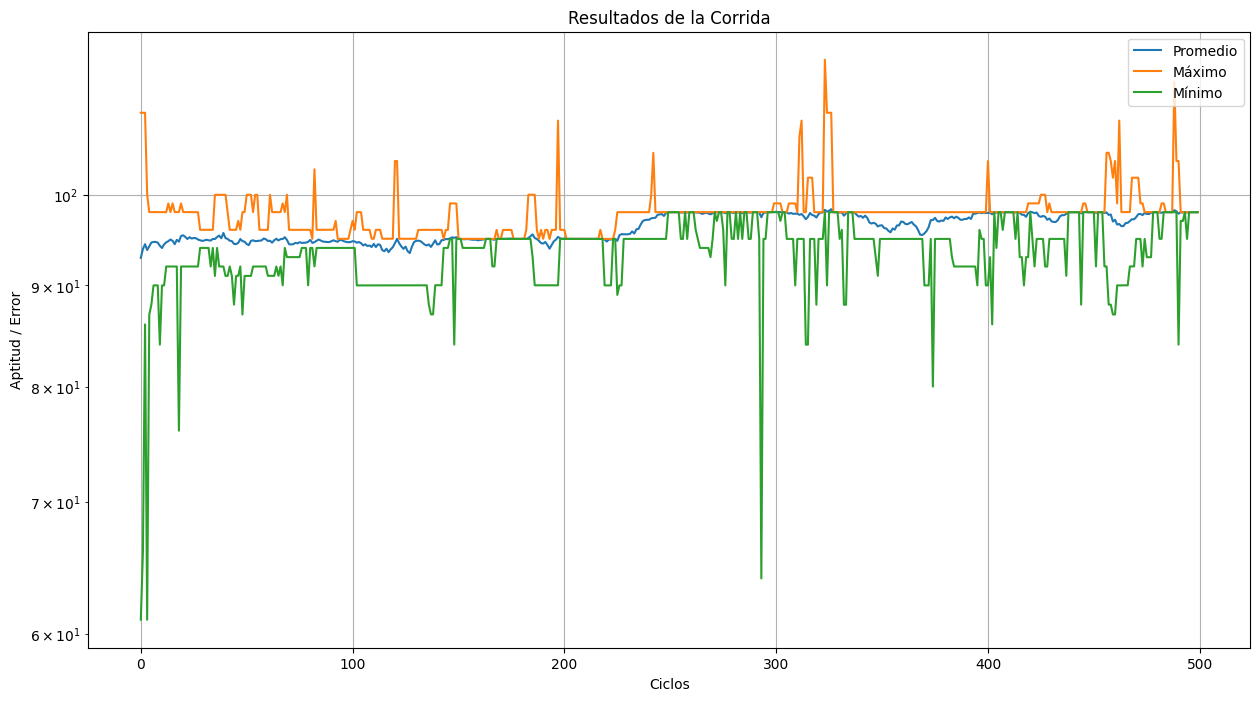

In [9]:
#@title MOSTRAR GRÁFICO DE LA CORRIDA
plt.figure(figsize=(15,8))
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMaxAptitud)
plt.plot(ciclosMinAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud / Error')
plt.legend(['Promedio', 'Máximo', 'Mínimo'], loc='upper right')
plt.grid(True)
USAR_ESCALA_LOG = True #@param {type:"boolean"}
if USAR_ESCALA_LOG:
  plt.yscale('log')
plt.show()


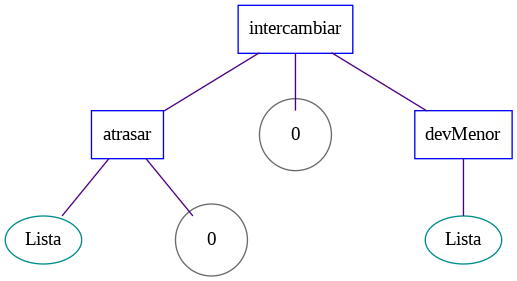





intercambiar(atrasar(Lista, 0), 0, devMenor(Lista))
 -  [57, 62, 60, 34, 95, 74] (errores  5.0 ) -->  [34, 57, 60, 62, 95, 74] (errores  1.0 )
 -  [46, 52, 50, 87, 32, 30, 97] (errores  10.0 ) -->  [30, 46, 50, 87, 32, 52, 97] (errores  4.0 )
 -  [97, 75, 61, 32, 10, 15, 79, 36, 55, 77] (errores  25.0 ) -->  [10, 97, 61, 32, 75, 15, 79, 36, 55, 77] (errores  19.0 )
 -  [54, 58, 16, 24, 91, 35, 9, 19, 34, 27] (errores  27.0 ) -->  [9, 54, 16, 24, 91, 35, 58, 19, 34, 27] (errores  19.0 )
 -  [98, 87, 72, 58, 81, 43, 14, 14, 74] (errores  28.0 ) -->  [14, 98, 72, 58, 81, 43, 87, 14, 74] (errores  18.0 )
Cantidad Errores :  61.007   (antes  95.007 )




In [10]:
#@title MOSTRAR GRAFICO DE LA EXPRESIÓN
## CORRESPONDIENTE AL MEJOR INDIVIDUO
nodes, edges, labels = gp.graph( mejorIndCorrida )

g = pgv.AGraph(overlap=False, splines='polyline') # indica tipo de uniones
g.graph_attr['label']='' # título
g.graph_attr['ranksep']='0.6' # separación entre niveles
g.graph_attr['nodesep']='1' # separación en el mismo nivel

g.node_attr['shape']='box'
g.node_attr['color']='blue'
g.edge_attr['color']='indigo'
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]
    if labels[i]=='Lista' or labels[i]=='LargoLista':
      n.attr['shape']='oval'
      n.attr['color']='cyan4'
    elif str(labels[i]).isnumeric():
      n.attr['shape']='circle'
      n.attr['color']='dimgray'

# genera una imagen temporal con el árbol y la muestra
auxFile = tempfile.NamedTemporaryFile(suffix=".png")
g.draw(auxFile.name,format="png")
display(Image.open(auxFile.name))


# Aplica y muesta el resultado
print("\n")
aplicaExpresion(mejorIndCorrida, True)
print("\n")
